Импорт библиотек

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Часть 1

Функция для генерации наборов данных

In [128]:
def make_data(n, seed):
    np.random.seed(seed)
    shift_matrix = np.array([[3, 3], [6, 9], [9, 3]])
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])
    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]},
                      columns=['x', 'y'])
    df = df.sample(frac=1.0)
    return df

Генерация набора данных

In [129]:
df_gen = make_data(99, 4318_04)
display(df_gen.head(2))
display(df_gen.info())

,x,y
208,183.873954,0.955791
15,36.467735,1.913227


<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 208 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       297 non-null    float64
 1   y       297 non-null    float64
dtypes: float64(2)
memory usage: 7.0 KB


None

Стандартизация данных

In [130]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_gen)
df_scaled

array([[ 1.20589142e+00, -1.01735372e+00],
       [-1.55881310e+00, -3.82419339e-01],
       [-2.09483577e-01,  1.38006518e+00],
       [-6.57001079e-01,  1.51951226e+00],
       [ 3.42531863e-01,  1.48241248e+00],
       [ 6.34379009e-02,  1.36161413e+00],
       [ 1.76255177e+00, -2.99307830e-01],
       [ 1.06880639e+00, -1.03595914e+00],
       [ 7.82085733e-01, -5.23730099e-01],
       [-1.36958922e+00,  3.68781107e-02],
       [-5.65084548e-02,  1.62533462e+00],
       [-9.56961576e-01, -4.85370849e-01],
       [ 2.95438626e-01,  2.03305570e+00],
       [-9.52260379e-01, -1.49238632e-01],
       [ 1.33648515e+00, -2.78047049e-01],
       [ 1.25318972e-01,  7.68685956e-01],
       [ 4.54180919e-01,  2.02954785e+00],
       [-2.39158453e-01,  1.25296734e+00],
       [ 1.54970839e+00, -8.78471264e-01],
       [-9.95658470e-01, -9.26586506e-01],
       [-7.20309736e-01, -4.39459576e-01],
       [ 1.39207202e+00, -9.13083396e-01],
       [ 6.43841878e-01, -1.75818305e-01],
       [ 1.

Кластеризация методов KMeans

cluster
1    198
0     99
Name: count, dtype: int64
cluster
1    99
0    99
2    99
Name: count, dtype: int64
cluster
2    99
3    98
0    57
1    43
Name: count, dtype: int64


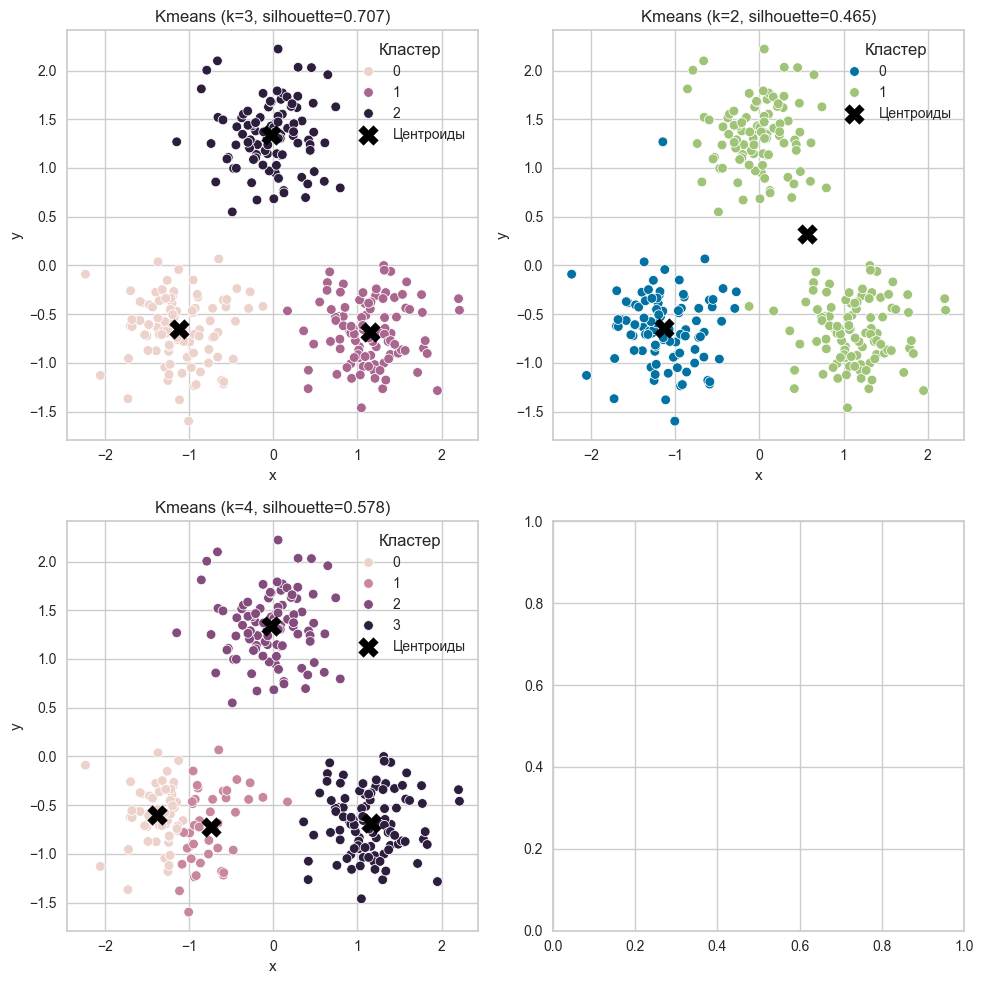

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster(n, df, ax=None):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(df)

    df_with_clusters = pd.DataFrame(
        np.column_stack((df, labels)),
        columns=['x', 'y', 'cluster']
    )

    df_with_clusters['cluster'] = df_with_clusters['cluster'].astype(int)
    print(df_with_clusters['cluster'].value_counts())
    centers = np.asarray(kmeans.cluster_centers_)
    silhouette = silhouette_score(df, labels)

    # If no axis provided, create a standalone figure (keeps backward compatibility)
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        created_fig = True

    sns.scatterplot(data=df_with_clusters, x='x', y='y', hue='cluster', ax=ax)
    ax.scatter(centers[:, 0], centers[:, 1], marker='X', s=200, label='Центроиды', c='black')
    ax.legend(title='Кластер', loc='best')
    ax.set_title(f'Kmeans (k={n}, silhouette={silhouette:.3f})')

    if created_fig:
        plt.tight_layout()
        plt.show()


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
cluster(2, df_scaled, ax=axes[0][1])
cluster(3, df_scaled, ax=axes[0][0])
cluster(4, df_scaled, ax=axes[1][0])
plt.tight_layout()
plt.show()

В результате обучения моделей для 2-4 кластеров видно, что наилучший результат показывает n_clusters=3.

При недостаточном количестве кластеров, модель пытается объединить два очевидно различных кластера. При избыточном количестве - делит один из кластеров пополам (43+57=99).

Этот вывод подтверждается и визуально, и по метрикам коэффициента силуэта: 0.7 для 3 кластеров значительно лучше остальных результатов.

График локтя для этого же датасета

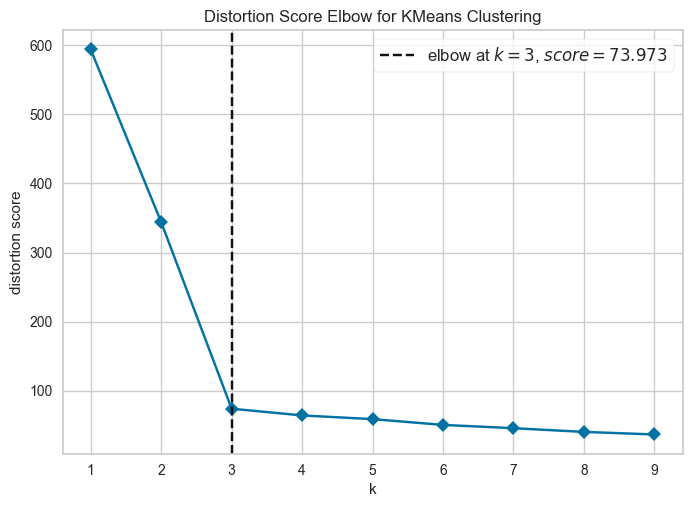

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [132]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,10), timings=False,)
visualizer.fit(df_scaled)
visualizer.show()

График локтя также показывает перелом при значении k=3, что подтверждает полученный в предыдущем опыте результаты.

# Часть 2

Вариант 4.

- age — возраст заёмщика (лет), числовой.
- annual_income — годовой доход, USD/год, числовой (широкий диапазон).
- employment_type — тип занятости: Salaried / Self-Employed / Unemployed, категориальный.
- education — образование: HS / Bachelors / Masters / PhD, категориальный.
- loan_amount — сумма кредита, USD, числовой (широкий диапазон).
- interest_rate_pct — процентная ставка по кредиту, % годовых, числовой.
- term_months — срок кредита, месяцев (набор фиксированных значений:
24/36/48/60/72, числовой/категориальный.
- credit_score — кредитный скор (от 300 до 850), числовой.
- num_open_accounts — число открытых кредитных счетов, целочисленный
счётчик.
- delinquency_30d — просрочка платежа 30 дней: Yes / No, категориальный.
- residence_type — жильё: Own / Rent / Mortgage, категориальный.
- Default — целевой класс: 1  дефолт по кредиту, 0  нет.

In [133]:
df = pd.read_csv("bank_loan_default.csv")
df.info()
display(df.shape)
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3041 non-null   int64  
 1   annual_income      3041 non-null   float64
 2   employment_type    3041 non-null   object 
 3   education          3041 non-null   object 
 4   loan_amount        3041 non-null   float64
 5   interest_rate_pct  3041 non-null   float64
 6   term_months        3041 non-null   int64  
 7   credit_score       3041 non-null   float64
 8   num_open_accounts  3041 non-null   int64  
 9   delinquency_30d    3041 non-null   object 
 10  residence_type     3041 non-null   object 
 11  Default            3041 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 285.2+ KB


(3041, 12)

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,Default
0,42,57272.0,Self-Employed,Masters,8516.0,5.85,48,730.0,10,No,Own,0
1,51,45786.0,Salaried,Masters,13760.0,9.97,36,677.0,7,No,Mortgage,0
2,69,42359.0,Salaried,Bachelors,2569.0,13.75,48,624.0,2,No,Own,0
3,65,50709.0,Self-Employed,Masters,13204.0,8.70,48,698.0,3,No,Rent,0
4,30,46272.0,Salaried,HS,7700.0,7.53,48,532.0,7,No,Rent,0


Переименование колонки

In [134]:
df.columns = df.columns.str.lower()

Проверка на неявные дубликаты

In [135]:
df.employment_type.value_counts()

employment_type
Salaried         2132
Self-Employed     682
Unemployed        227
Name: count, dtype: int64

In [136]:
df.education.value_counts()

education
Bachelors    1181
HS            956
Masters       748
PhD           156
Name: count, dtype: int64

In [137]:
df.delinquency_30d.value_counts()


delinquency_30d
No     2668
Yes     373
Name: count, dtype: int64

In [138]:
(df.residence_type.value_counts())


residence_type
Rent        1241
Own         1065
Mortgage     735
Name: count, dtype: int64

Проверка на явные дубликаты

In [139]:
df.duplicated().sum()

np.int64(0)

В результате пред обработки данных проверены категориальные типы данных, неявных дубликатов не найдено. Явных дубликатов не найдено.

Исправлено название одного из признаков.

In [140]:
df.describe()

,age,annual_income,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,default
count,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000
mean,47.088787,45746.182835,10683.309306,9.436271,47.696153,681.263400,4.545873,0.203880
std,15.600123,23572.506169,7384.866768,3.523466,13.883245,73.007065,2.175964,0.402947
min,21.000000,7433.000000,1016.000000,1.900000,24.000000,417.000000,0.000000,0.000000
25%,34.000000,28741.000000,5540.000000,7.150000,36.000000,632.000000,3.000000,0.000000
50%,47.000000,40826.000000,8797.000000,9.300000,48.000000,683.000000,4.000000,0.000000
75%,60.000000,57428.000000,13464.000000,11.440000,60.000000,733.000000,6.000000,0.000000
max,74.000000,237129.000000,69139.000000,33.888000,72.000000,850.000000,14.000000,1.000000


Целевым признаком в данном датасете является `default` - дефолт по кредиту.

Для выявление закономерностей построена матрица диаграмм рассеивания

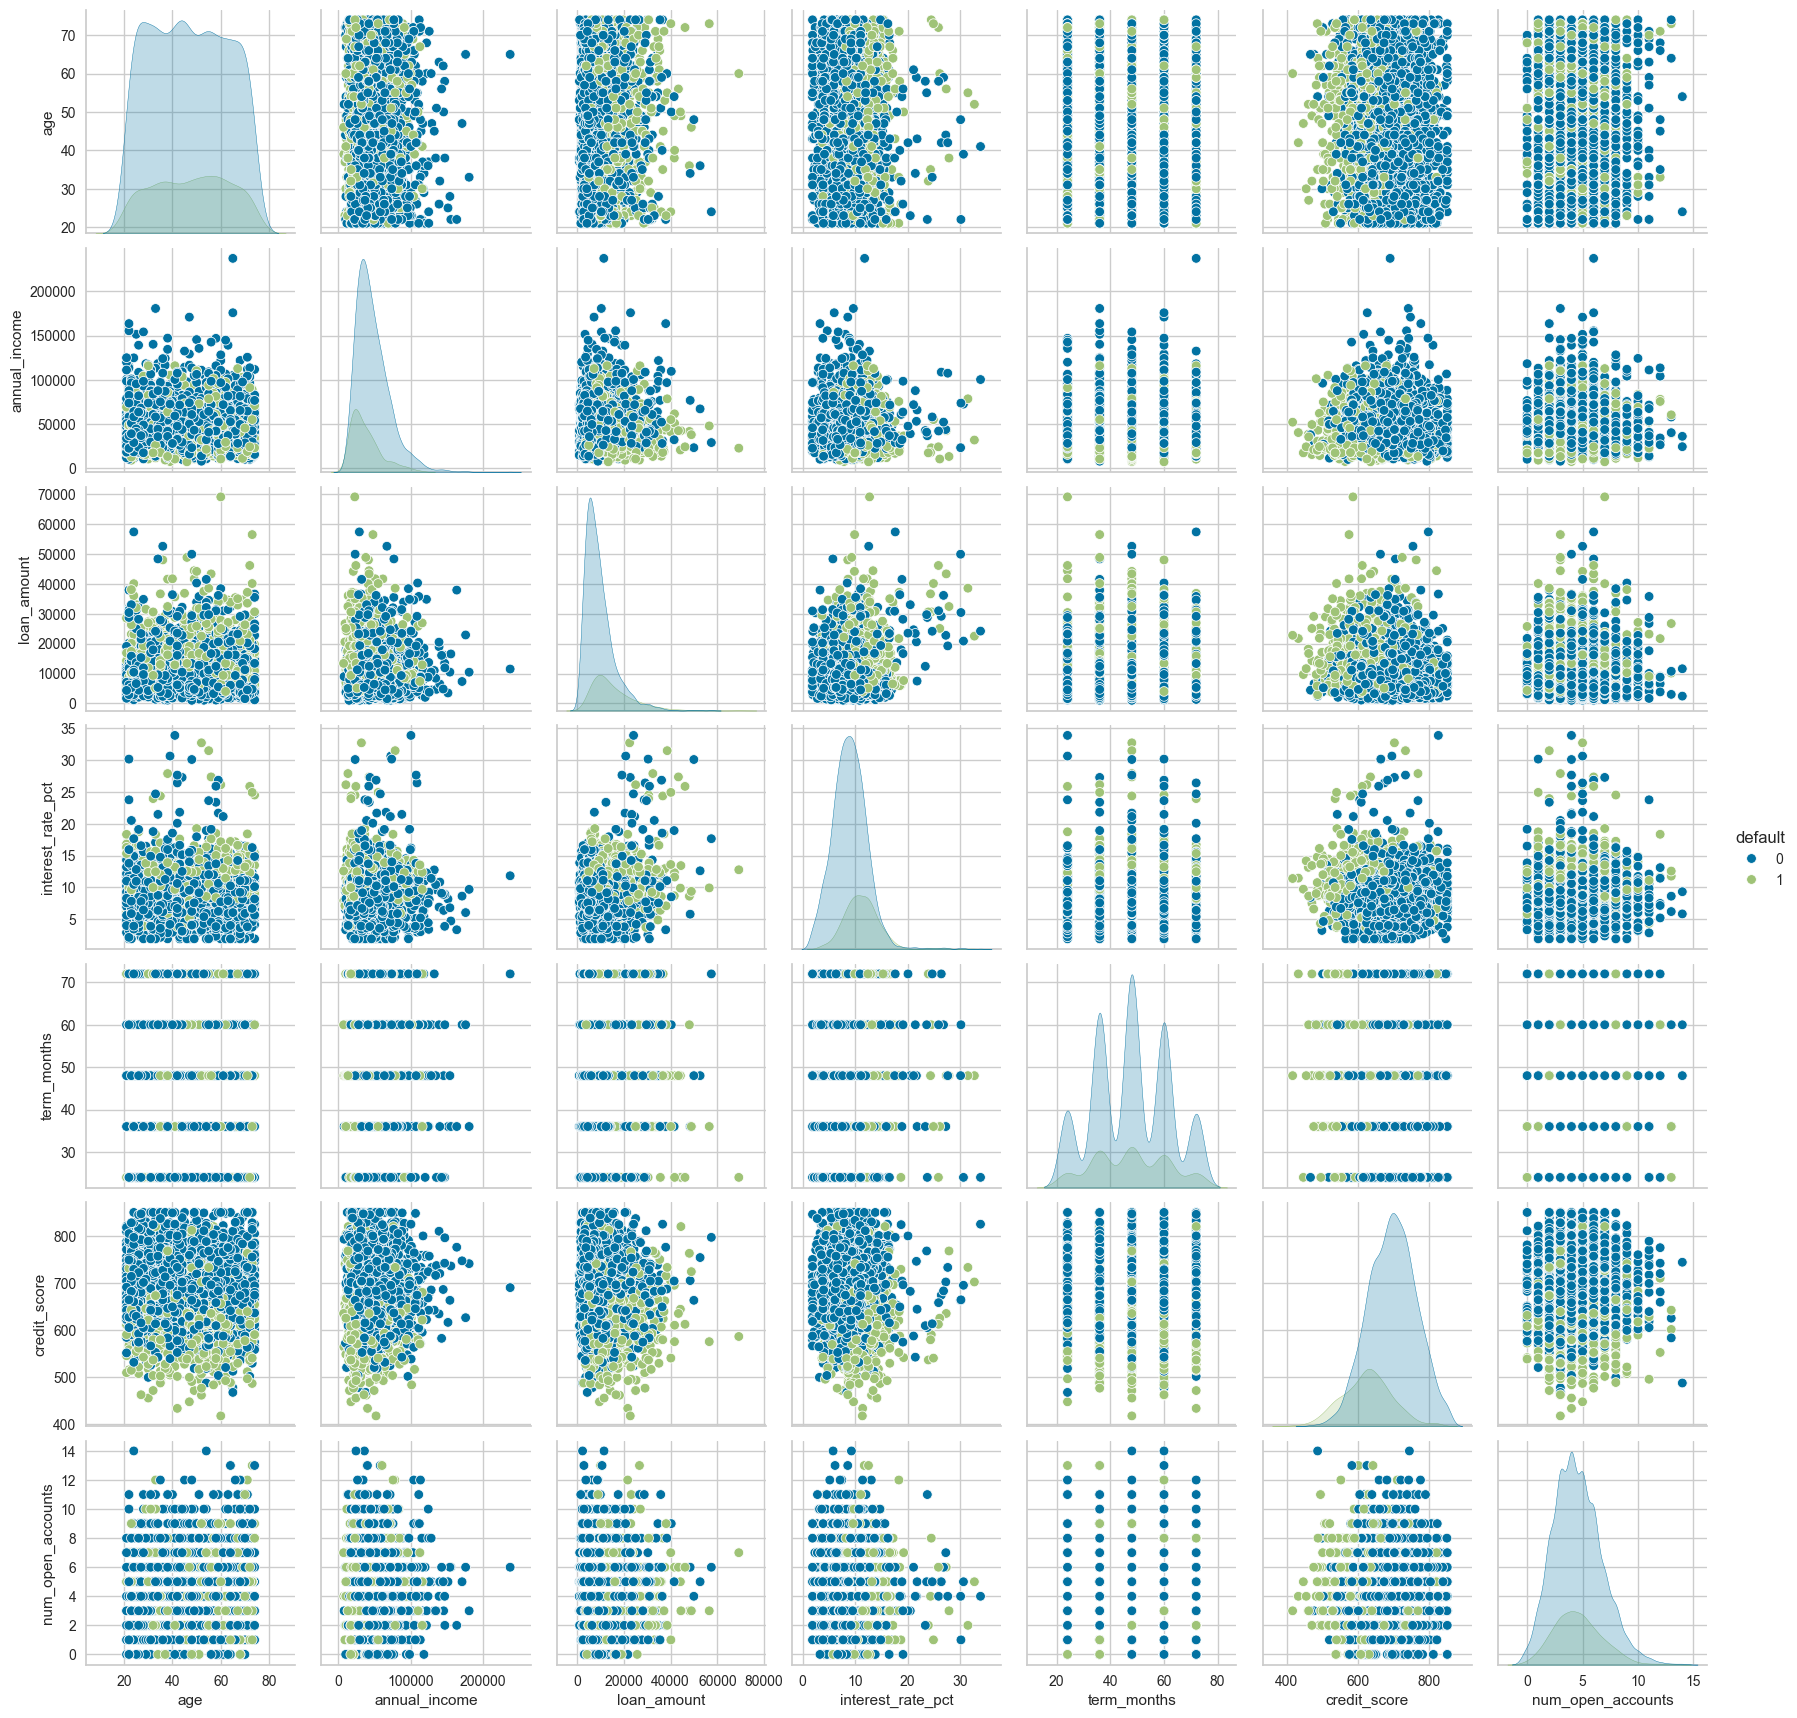

In [141]:
sns.pairplot(df, hue='default')


Визуально можно сделать следующие выводы:
- заемщики с меньшим процентом с меньшим шансом оказываются в дефолте
- чем выше кредитный счет, тем ниже шанс дефолта
- чем выше доход, тем ниже шанс дефолта

Возможно, более сложные зависимости не заметны визуально.

Выполним кодирование категориальных типов данных

In [142]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

for col in df.select_dtypes(include='object').columns:
	df[col] = oe.fit_transform(pd.DataFrame(df[col]))

Выполним стандартизацию числовых данных

In [143]:
df_with_clusters = df.copy()

y = df.default
X = df.drop('default', axis=1)

X_scaled = scaler.fit_transform(X)

Подберем оптимальное количество кластеров методом локтя

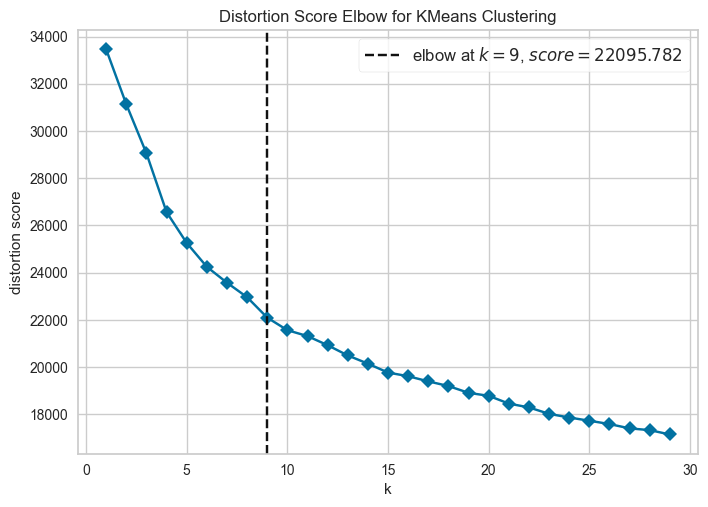

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [144]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,30), timings=False)
visualizer.fit(X_scaled)
visualizer.show()

Метод локтя не показывает одного явно верного количества кластеров, однако наиболее подходящим выглядит значение k=9. Для более разнообразной оценки также выполним кластеризацию при k=6. (тоже похоже на перелом)

In [145]:

from sklearn.metrics import completeness_score

from sklearn.metrics import homogeneity_score

from sklearn.metrics import adjusted_mutual_info_score

from sklearn.metrics import adjusted_rand_score


def cluster_and_avg(n, ret=False):
    k_means = KMeans(n_clusters=n, random_state=5)
    labels = k_means.fit_predict(X_scaled)
    centroids = k_means.cluster_centers_

    print(f"\nk={n}")

    ari = adjusted_rand_score(y,labels)
    print(f"{ari=:0.4f}")

    ami = adjusted_mutual_info_score(y, labels)
    print(f"{ami=:0.4f}")

    homogeneity = homogeneity_score(y, labels)
    print(f"{homogeneity=:0.4f}")

    completeness = completeness_score(y, labels)
    print(f"{completeness=:0.4f}")

    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"{silhouette_avg=:0.4f}")

    if ret:
        return labels, centroids


In [146]:
cluster_and_avg(10)
cluster_and_avg(9)
cluster_and_avg(8)

cluster_and_avg(6)
labels, centroids = cluster_and_avg(4, ret=True)
cluster_and_avg(5)


k=10
ari=0.0126
ami=0.0237
homogeneity=0.0670
completeness=0.0151
silhouette_avg=0.0787

k=9
ari=0.0104
ami=0.0192
homogeneity=0.0532
completeness=0.0125
silhouette_avg=0.0807

k=8
ari=0.0145
ami=0.0216
homogeneity=0.0567
completeness=0.0140
silhouette_avg=0.0785

k=6
ari=0.0206
ami=0.0245
homogeneity=0.0562
completeness=0.0163
silhouette_avg=0.0814

k=4
ari=0.1161
ami=0.0873
homogeneity=0.1534
completeness=0.0615
silhouette_avg=0.1027

k=5
ari=0.0376
ami=0.0365
homogeneity=0.0744
completeness=0.0248
silhouette_avg=0.0895


- ARI (Adjusted Rand Index) оценивает степень совпадения между кластеризацией и исходными метками с поправкой на случайные совпадения.
- AMI (Adjusted Mutual Information) измеряет взаимную информацию между кластерами и исходными метками.
- Homogeneity и Completeness: эти метрики проверяют, насколько кластеры однородны и полно отражают классы.
- Silhouette: метрика, которая показывает, насколько объекты внутри одного кластера похожи друг на друга по сравнению с объектами из других кластеров.


Выбранный вопреки алгоритму метода локтя параметр `k=5` на метриках показывает значительно лучшие результаты, чем `k=9`.
Однако, для полноты эксперимента были также вычислены метрики для некоторых других значений. Наилучший результат показало `k=4`, вопреки методу локтя.

In [147]:
df['cluster'] = labels
display(df.groupby('cluster').mean())
print(df.cluster.value_counts())

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,default
cluster,,,,,,,,,,,,
0,47.563003,45035.101877,0.415550,1.034853,10750.739946,9.641099,47.646113,676.884718,4.453083,1.0,1.182306,0.238606
1,46.322812,47498.724534,1.276901,0.984218,9141.348350,8.904376,46.519369,693.724534,4.523673,0.0,1.232425,0.144907
2,48.956912,45489.538600,0.163375,0.978456,19049.461041,12.064111,48.710952,625.163375,4.450628,0.0,1.166966,0.545781
3,46.605375,45170.979491,0.000000,0.921499,8130.019802,8.609272,47.889675,698.374823,4.618812,0.0,1.129420,0.089109


cluster
3    1414
1     697
2     557
0     373
Name: count, dtype: int64


- Кластер 2 - основной источник риска. Ключевые признаки:
    - Большая сумма займов, в среднем в 2 раза больше, чем в других категориях
    - Больший процент кредита, выше среднего на 3 п.п.
    - Немного меньший средний кредитный рейтинг
- Кластер 0 - средний риск
    - Высокая доля просрочек на 30 дней
    - Кредитный рейтинг около 670
    - Процент по кредиту чуть выше среднего
- Кластер 1 и 3 — низкий риск:
    - Лучшие кредитные рейтинги
    - Процент около 8-9%

Влияние трудоустройства тяжело оценить из-за кодировки.


## Дендрограмма

Построим дендрограмму для определения оптимального количества кластеров

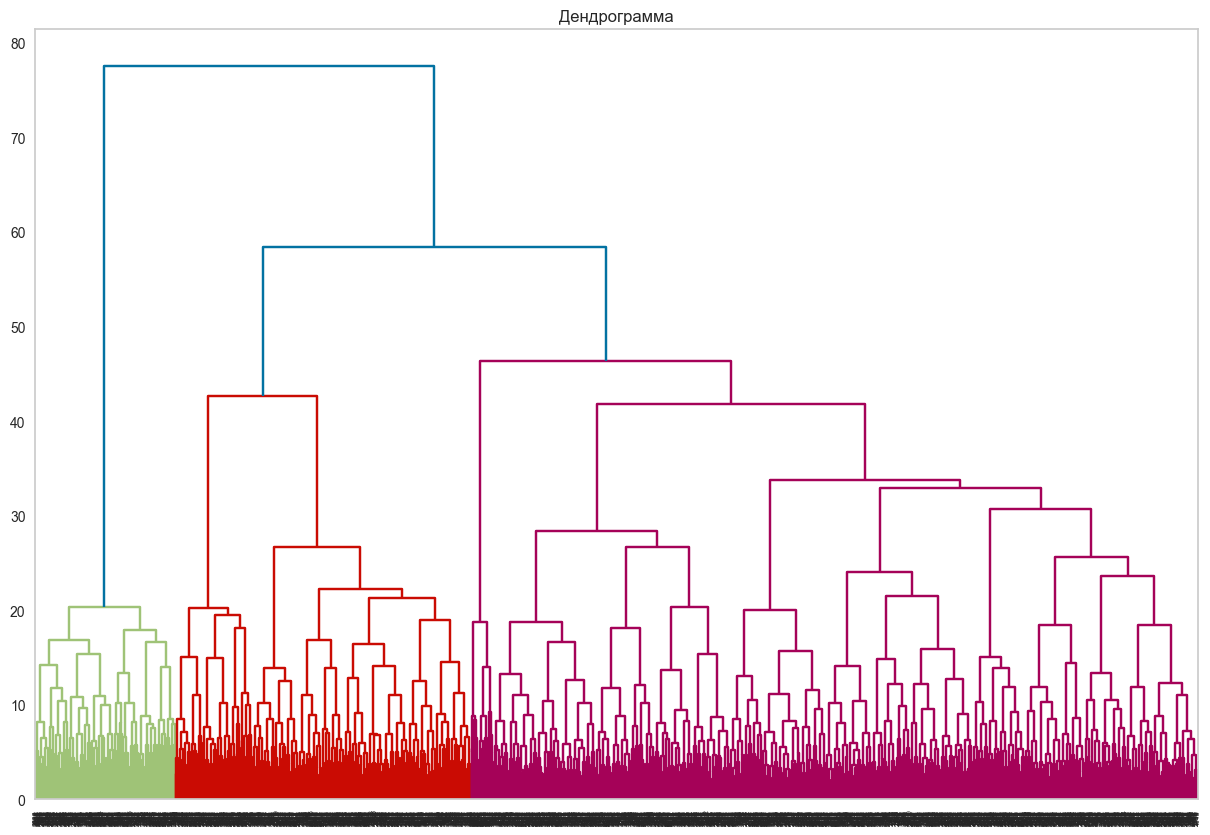

In [148]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

linked = linkage(X_scaled, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.grid(False)
plt.title('Дендрограмма')
plt.show()

Визуально можно определить, что самый большой вертикальный прыжок случается после объединения в 4 кластера. Оптимальное количество кластеров 4. Проверим, совпадают ли они с кластерами, полученными методов KMeans

In [149]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
df['cluster'] = clustering.fit_predict(X_scaled)
df.groupby('cluster').mean()

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,default
cluster,,,,,,,,,,,,
0,44.504528,54821.341527,1.087969,0.961190,9909.419146,9.051974,48.372574,683.798189,4.429495,0.003881,1.284605,0.161708
1,47.576087,43929.565217,0.415761,1.032609,10698.854891,9.624598,47.836957,676.160326,4.434783,1.000000,1.173913,0.241848
2,48.046171,42393.210212,0.067898,0.945139,10253.571320,9.244075,47.328626,681.734927,4.611624,0.000543,1.118957,0.203694
3,48.033898,42801.101695,0.288136,0.966102,34134.901695,19.293729,49.423729,665.169492,4.711864,0.016949,1.050847,0.525424


Полученные кластеры не совпадают с кластерами метода KMeans.

- Кластер 3 - высокий риск. Ключевой признак:
    - Высокая ставка кредита, в среднем 19 п.п.
    - На 20 пунктов ниже
    - В 3 раза выше среднего объем кредитов
- Кластеры 0, 1, 2 - средний риск. Включают в себя все оставшиеся записи.
    - не имеют между собой значимых различий.

Выбор количества кластеров сделен неверно. Необходимое количество кластеров - 2.



In [150]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
df['cluster'] = clustering.fit_predict(X_scaled)
df.groupby('cluster').mean()


,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,default
cluster,,,,,,,,,,,,
0,47.021698,45996.282080,0.367752,0.950243,10681.169098,9.410343,47.676768,681.965956,4.561167,0.001871,1.165357,0.198653
1,47.576087,43929.565217,0.415761,1.032609,10698.854891,9.624598,47.836957,676.160326,4.434783,1.000000,1.173913,0.241848


При уменьшении количества кластеров до 2-х - пропадает кластер с высоким риском. Возможно, следует использовать другой метод группировки. Продолжит использовать 4 кластера. Вычислим для них метрики

In [151]:
clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = clustering.fit_predict(X_scaled)

ari = adjusted_rand_score(y,labels)
print(f"{ari=:0.4f}")

ami = adjusted_mutual_info_score(y, labels)
print(f"{ami=:0.4f}")

homogeneity = homogeneity_score(y, labels)
print(f"{homogeneity=:0.4f}")

completeness = completeness_score(y, labels)
print(f"{completeness=:0.4f}")

silhouette_avg = silhouette_score(X_scaled, labels)
print(f"{silhouette_avg=:0.4f}")


ari=0.0108
ami=0.0086
homogeneity=0.0136
completeness=0.0070
silhouette_avg=0.1058


Параметры kmeans для сравнения:
```k=4
silhouette=-0.0072
ari=0.1161
ami=0.0873
homogeneity=0.1534
completeness=0.0615
silhouette_avg=0.1027```


KMeans показывает значительно лучшие результаты и по метрикам (кроме силуэтного коэфф., он равен), и по полезности полученных кластеров по дефолту.

# Вывод

В ходе выполнения лабораторной работы были изучены и применены на практике алгоритмы кластеризации данных. Были подобраны оптимальные значения количества кластеров как методом локтя, так и по изучению метрик получаемых кластеров, а так же визуальным способом по дендрограмме.

Алгоритм KMeans использован и на синтетической выборке (с показателем silhouette=0.7), и на реальном наборе данных по дефолтам по займам. При количестве кластеров k=4 выделено несколько полезных кластеров: один кластер с высоким риском, один со средним и два с низким рисками. (homogeneity=0.1534)

На датасете кредитов также был использован метод иерархической кластеризации, показавший сложность определения оптимальной методики и количества кластеров "на глаз". Он показал результат хуже, чем Kmeans. При k=5 метрика homogeneity оказалсь всего 0.0136 (в 10 раз меньше).